## Upload libriaries

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import os
import pathlib

In [3]:
%%bash
pip3 install --user pycocotools

## Get tensorflow/models or cd to parent directory

In [0]:
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

## Compile protobufs and install the object_detection package

In [5]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

# %%bash
# apt install protobuf-compiler
# protoc --version

# comment line in input_reader.proto:
# //import "object_detection/protos/image_resizer.proto";

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [6]:
%%bash 
cd models/research
pip3 install object_detection

## Import the Required Libraries

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

## Import the object detection module

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
# add file string_int_label_map_pb2.py to /usr/local/lib/python3.6/dist-packages/object_detection/protos
from object_detection.utils import label_map_util

## Model Preparation

### Loader

In [0]:
def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
                fname=model_name, 
                origin=base_url + model_file,
                untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"

    model = tf.saved_model.load(str(model_dir), tags=None)
    model = model.signatures['serving_default']

    return model

### Loading label map

In [0]:
# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
# category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
category_index = {1: {'id': 1, 'name': "person"}, 2: {'id': 2, 'name': "bicycle"}, 3: {'id': 3, 'name': "car"}, 
                  4: {'id': 4, 'name': "motorcycle"}, 5: {'id': 5, 'name': "airplane"}, 6: {'id': 6, 'name': "bus"}, 
                  7: {'id': 7, 'name': "train"}, 8: {'id': 8, 'name': "truck"}, 9: {'id': 9, 'name': "boat"}, 
                  10: {'id': 10, 'name': "traffic light"}, 11: {'id': 11, 'name': "fire hydrant"}, 
                  13: {'id': 13, 'name': "stop sign"}, 14: {'id': 14, 'name': "parking meter"}, 
                  15: {'id': 15, 'name': "bench"}, 16: {'id': 16, 'name': "bird"}, 17: {'id': 17, 'name': "cat"}, 
                  18: {'id': 18, 'name': "dog"}, 19: {'id': 19, 'name': "horse"}, 20: {'id': 20, 'name': "sheep"}, 
                  21: {'id': 21, 'name': "cow"}, 22: {'id': 22, 'name': "elephant"}, 23: {'id': 23, 'name': "bear"}, 
                  24: {'id': 24, 'name': "zebra"}, 25: {'id': 25, 'name': "giraffe"}, 27: {'id': 27, 'name': "backpack"}, 
                  28: {'id': 28, 'name': "umbrella"}, 31: {'id': 31, 'name': "handbag"}, 32: {'id': 32, 'name': "tie"}, 
                  33: {'id': 33, 'name': "suitcase"}, 34: {'id': 34, 'name': "frisbee"}, 35: {'id': 35, 'name': "skis"}, 
                  36: {'id': 36, 'name': "snowboard"}, 37: {'id': 37, 'name': "sports ball"}, 38: {'id': 38, 'name': "kite"}, 
                  39: {'id': 39, 'name': "baseball bat"}, 40: {'id': 40, 'name': "baseball glove"}, 
                  41: {'id': 41, 'name': "skateboard"}, 42: {'id': 42, 'name': "surfboard"}, 
                  43: {'id': 43, 'name': "tennis racket"}, 44: {'id': 44, 'name': "bottle"}, 46: {'id': 46, 'name': "wine glass"}, 
                  47: {'id': 47, 'name': "cup"}, 48: {'id': 48, 'name': "fork"}, 49: {'id': 49, 'name': "knife"}, 
                  50: {'id': 50, 'name': "spoon"}, 51: {'id': 51, 'name': "bowl"}, 52: {'id': 52, 'name': "banana"}, 
                  53: {'id': 53, 'name': "apple"}, 54: {'id': 54, 'name': "sandwich"}, 55: {'id': 55, 'name': "orange"}, 
                  56: {'id': 56, 'name': "broccoli"}, 57: {'id': 57, 'name': "carrot"}, 58: {'id': 58, 'name': "hot dog"}, 
                  59: {'id': 59, 'name': "pizza"}, 60: {'id': 60, 'name': "donut"}, 61: {'id': 61, 'name': "cake"}, 
                  62: {'id': 62, 'name': "chair"}, 63: {'id': 63, 'name': "couch"}, 64: {'id': 64, 'name': "potted plant"}, 
                  65: {'id': 65, 'name': "bed"}, 67: {'id': 67, 'name': "dining table"}, 70: {'id': 70, 'name': "toilet"}, 
                  72: {'id': 72, 'name': "tv"}, 73: {'id': 73, 'name': "laptop"}, 74: {'id': 74, 'name': "mouse"}, 
                  75: {'id': 75, 'name': "remote"}, 76: {'id': 76, 'name': "keyboard"}, 77: {'id': 77, 'name': "cell phone"}, 
                  78: {'id': 78, 'name': "microwave"}, 79: {'id': 79, 'name': "oven"}, 80: {'id': 80, 'name': "toaster"}, 
                  81: {'id': 81, 'name': "sink"}, 82: {'id': 82, 'name': "refrigerator"}, 84: {'id': 84, 'name': "book"}, 
                  85: {'id': 85, 'name': "clock"}, 86: {'id': 86, 'name': "vase"}, 87: {'id': 87, 'name': "scissors"}, 
                  88: {'id': 88, 'name': "teddy bear"}, 89: {'id': 89, 'name': "hair drier"}, 90: {'id': 90, 'name': "toothbrush"}}

In [21]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.png")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/me_256.png')]

## Object Detection Model using TensorFlow API

### Load an object detection model

In [22]:
model_name = 'ssd_mobilenet_v2_coco_2018_03_29'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0604 01:48:47.762640 139719206258560 saver.py:1512] Saver not created because there are no variables in the graph to restore


### Check the model’s input signature (it expects a batch of 3-color images of type int8)

In [13]:
print(detection_model.inputs)
detection_model.output_dtypes

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

### Add a wrapper function to call the model and cleanup the outputs

In [0]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    output_dict = model(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                   for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                  image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

## Run it on each test image and show the results

In [0]:
def show_inference(model, image_path):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.array(Image.open(image_path))
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
                          image_np,
                          output_dict['detection_boxes'],
                          output_dict['detection_classes'],
                          output_dict['detection_scores'],
                          category_index,
                          instance_masks=output_dict.get('detection_masks_reframed', None),
                          use_normalized_coordinates=True,
                          line_thickness=8)

    display(Image.fromarray(image_np))

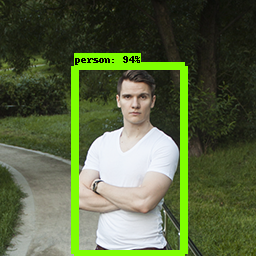

In [24]:
for image_path in TEST_IMAGE_PATHS:
    show_inference(detection_model, image_path)